In [1]:

import os

DATA_PATH = "orders.csv"  # path to your dataset
SAVE_DIR = "/mnt/data/order_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

TARGET = "order_count"  # Assuming dataset has daily order counts; otherwise will compute from order_id


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [7]:
# Load dataset
try:
    df = pd.read_csv(DATA_PATH)
except Exception as e:
    raise SystemExit(f"Error loading {DATA_PATH}: {e}")

print("Columns:", df.columns.tolist())
print("Sample data:")
display(df.head())

# If the dataset has order_id per row, aggregate daily orders
if 'order_id' in df.columns:
    # Convert 'order_hour_of_day' to numeric, coercing errors
    df['order_hour_of_day'] = pd.to_numeric(df['order_hour_of_day'], errors='coerce')
    # Aggregate by the hour of the day
    daily_orders = df.groupby('order_hour_of_day').size().reset_index(name='order_count')
else:
    daily_orders = df.copy()

Columns: ['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
Sample data:


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [16]:
# Feature engineering
# Since we aggregated by order_hour_of_day, we cannot extract day, month, or day of week directly
# from a date column that does not exist.

# Moving average features based on order_count
daily_orders['orders_ma7'] = daily_orders['order_count'].rolling(window=7).mean().bfill()
daily_orders['orders_ma30'] = daily_orders['order_count'].rolling(window=30).mean().bfill()

# Lag features based on order_count
daily_orders['lag1'] = daily_orders['order_count'].shift(1).bfill()
daily_orders['lag7'] = daily_orders['order_count'].shift(7).bfill()

display(daily_orders.head())

,order_hour_of_day,order_count,orders_ma7,orders_ma30,lag1,lag7
0,0,22758,13399.142857,NaN,22758.0,22758.0
1,1,12398,13399.142857,NaN,22758.0,22758.0
2,2,7539,13399.142857,NaN,12398.0,22758.0
3,3,5474,13399.142857,NaN,7539.0,22758.0
4,4,5527,13399.142857,NaN,5474.0,22758.0


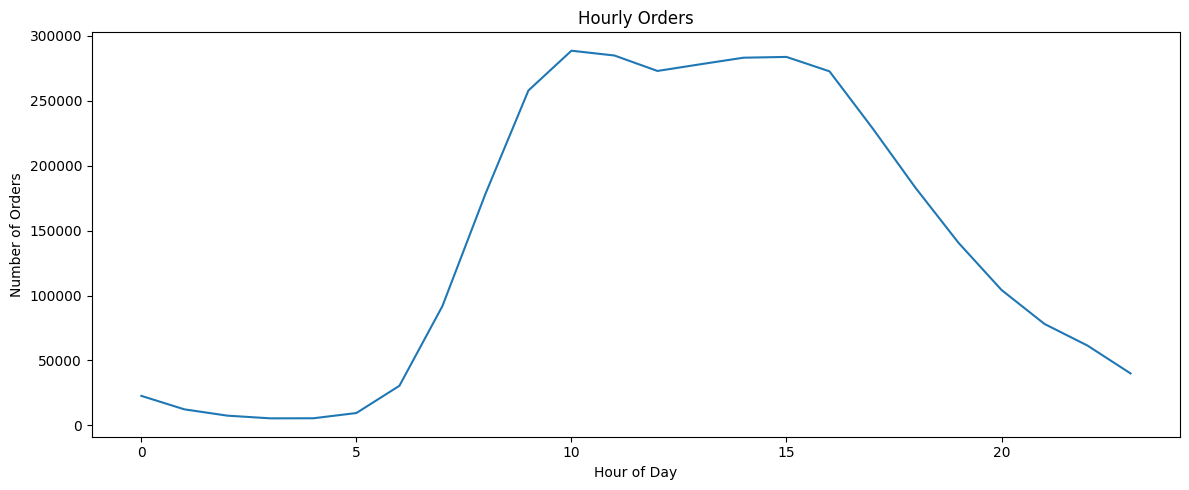

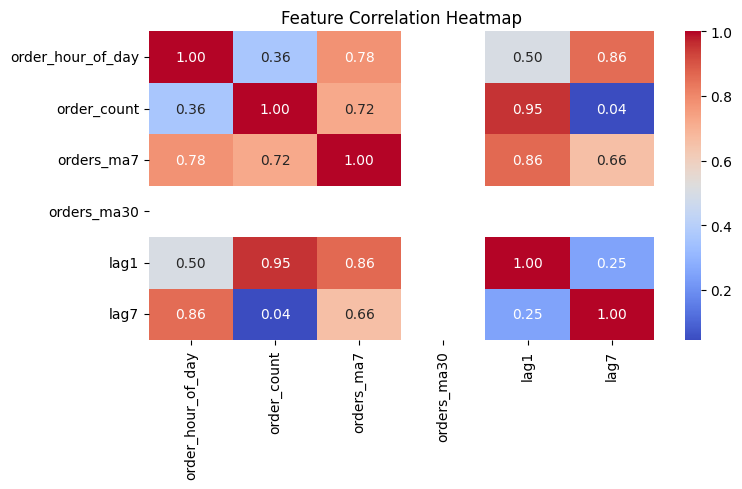

In [11]:
# EDA
plt.figure(figsize=(12,5))
plt.plot(daily_orders['order_hour_of_day'], daily_orders['order_count'])
plt.title("Hourly Orders")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/hourly_orders_timeseries.png")
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,5))
sns.heatmap(daily_orders.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/correlation_heatmap.png")
plt.show()

In [20]:
# Features and target
features = ['orders_ma7','lag1','lag7'] # Removed 'orders_ma30'
X = daily_orders[features]
y = daily_orders['order_count']

# Removed train/test split as the dataset is small and represents a daily cycle
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Use the entire dataset for training and evaluation
X_train = X
y_train = y
X_test = X # Use the entire dataset for prediction to evaluate model performance on the training data
y_test = y # Use the entire dataset for evaluating model performance on the training data

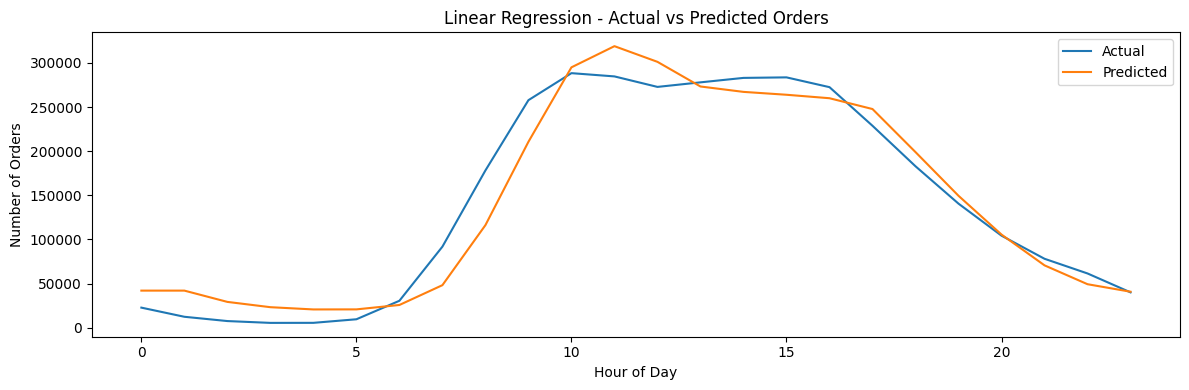

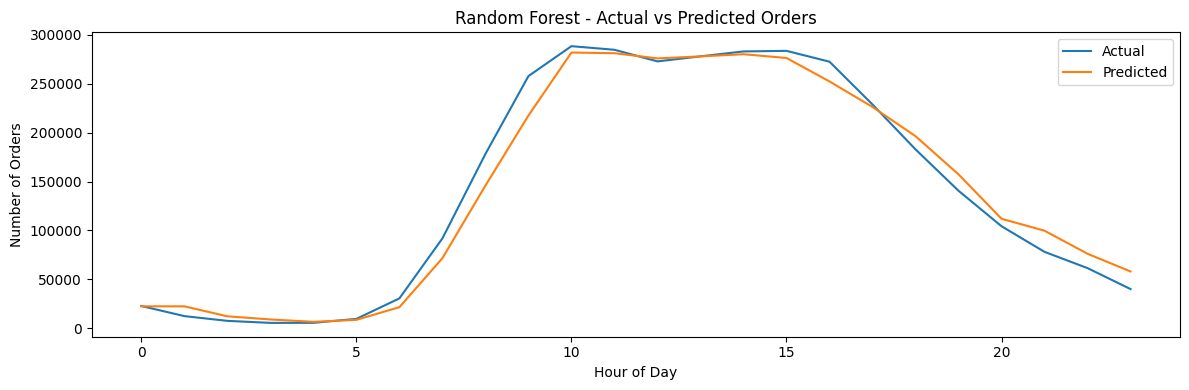

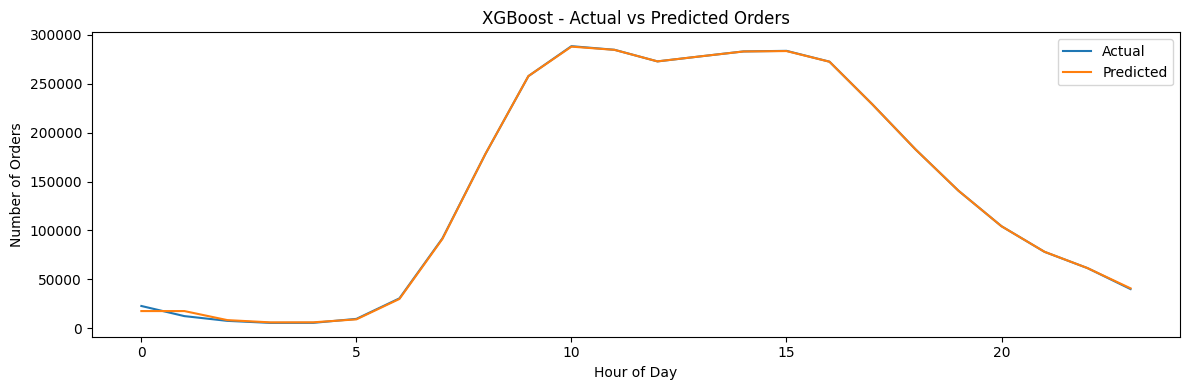

,Model,MAE,RMSE,R2
0,Linear Regression,19164.694783,24266.455107,0.952823
1,Random Forest,10861.032222,14955.330296,0.982081
2,XGBoost,652.492249,1534.867014,0.999811


In [21]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = []

# No need to drop NaNs here as they are handled in feature engineering
# X_train = X_train.dropna()
# y_train = y_train[X_train.index] # Align y_train with the cleaned X_train

# X_test = X_test.dropna()
# y_test = y_test[X_test.index] # Align y_test with the cleaned X_test


for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse_val = rmse(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse_val, 'R2': r2})

    # Plot actual vs predicted
    # Adjust plotting to use the index of the cleaned X_test for x-axis
    plt.figure(figsize=(12,4))
    plt.plot(X_test.index, y_test.values, label='Actual')
    plt.plot(X_test.index, preds, label='Predicted')
    plt.title(f"{name} - Actual vs Predicted Orders")
    plt.xlabel("Hour of Day") # Updated label
    plt.ylabel("Number of Orders")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{SAVE_DIR}/{name.replace(' ','_')}_actual_vs_pred.png")
    plt.show()

results_df = pd.DataFrame(results)
results_df.to_csv(f"{SAVE_DIR}/model_comparison.csv", index=False)
results_df

In [22]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=results_df)

https://docs.google.com/spreadsheets/d/17bzminQH66LjjLVcHLOHIt-PEvImRCHp582I2c6Drbc/edit#gid=0
